In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [4]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [5]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [6]:
from narrative import nar181026_heat_confidence_genes
from narrative import nar181205_networks

In [7]:
save_images = True
mode = 'validated_RNA'

In [8]:
outfolder = '211004_mouse_tissue_effects'

In [9]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [10]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

all_de = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['younger']==4) &
    (all_de['gene_ncbi'].isin(ref_genes))

]

In [11]:
from scipy.stats import spearmanr

In [12]:
from natsort import natsorted

In [13]:
conditions = natsorted(all_de['condition'].unique())

In [14]:
out = pd.DataFrame(index=conditions, columns=[
    'corr', 'pval'
]).rename_axis('condition')

In [15]:
if mode == 'validated_RNA':

    pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
        'Genbank_validated_RNA: full_SumACGT': 'length'
    })

elif mode == 'gene':
    pr = properties.genbank_gene(10090)[['gene_ncbi', 'Genbank__gene: SumACGT']].rename(columns={
            'Genbank__gene: SumACGT': 'length'
        })
else:
    raise AssertionError('Something wrong')

pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

In [16]:
def get_imbalance(replicate, conditions):
    
    out = pd.DataFrame(index=conditions, columns=[
        'corr', 'pval'
    ]).rename_axis('condition')

    for condition in conditions:
        d = all_de[
            (all_de['de_unit']==replicate) & (all_de['condition']==condition)
        ]
        
        if d.shape[0] > 0 :

            d = d[['gene_ncbi', 'o_over_y', 'log_padj', 'log_pvalue']].dropna()
            d = pd.merge(d, pr)

            r, p = spearmanr(d['log_length'], d['o_over_y'])
            d = d.set_index('gene_ncbi')

            out.loc[condition, 'corr'] = r
            out.loc[condition, 'pval'] = p

    out = out.reset_index()
    
    return out

In [17]:
first = get_imbalance('first', conditions)
second = get_imbalance('second', conditions)

In [18]:
both = get_imbalance('both', conditions)

In [19]:
first[first['condition']=='Stomach_0_4_24']

,condition,corr,pval
63,Stomach_0_4_24,0.0210891,0.0350823


In [20]:
second[second['condition']=='Stomach_0_4_24']

,condition,corr,pval
63,Stomach_0_4_24,-0.364331,0


In [21]:
both[both['condition']=='Stomach_0_4_24']

,condition,corr,pval
63,Stomach_0_4_24,-0.438255,2.5601e-268


In [22]:
master = pd.merge(first, second, on='condition', suffixes=('_first', '_second'))

In [23]:
master = pd.merge(master, both)

In [24]:
master['down'] = master[['corr_first', 'corr_second']].min(1)
master['up'] = master[['corr_first', 'corr_second']].max(1)

In [25]:
master['upper_error'] = master['up'] - master['corr']
master['down_error'] = master['corr'] - master['down']

In [26]:
master = pd.merge(
    master,
    all_de[['condition', 'tissue', 'older']].drop_duplicates()
)



In [27]:
tissue_dict = {
    'Adrenal': 'Adrenal gland',
    'BAT': 'Brown adipose tissue',
    'Blood': 'Blood',
    'Brain': 'Frontal cortex',
    'Cerebellum': 'Cerebellum',
    'Esophagus': 'Esophagus',
    'GutEP': 'Gut epithelium',
    'Heart': 'Heart',
    'Kidney': 'Kidney',
    'LI': 'Large intestine',
    'Liver': 'Liver',
    'Lung': 'Lung',
    'MuscSat': 'Muscle',
    'SI': 'Small intestine',
    'Skin': 'Skin',
    'Stomach': 'Stomach',
    'WAT': 'White adipose tissue'
}

In [28]:
master['tissue'] = master['tissue'].replace(
     tissue_dict
)

In [29]:
m = master[master['older']==24]

In [30]:
m = m.sort_values('corr', ascending=False)

In [31]:
m

,condition,corr_first,pval_first,corr_second,pval_second,corr,pval,down,up,upper_error,down_error,tissue,older
15,Brain_0_4_24,-0.128151,4.6753e-41,0.615278,0,0.193236,7.13538e-96,-0.128151,0.615278,0.422042,0.321388,Frontal cortex,24.0
47,Lung_0_4_24,-0.0671267,2.3734e-11,0.437565,8.29861e-220,0.143915,5.5887e-49,-0.067127,0.437565,0.29365,0.211041,Lung,24.0
59,Skin_0_4_24,0.407185,0,-0.284306,5.65958e-21,0.140789,1.98503e-50,-0.284306,0.407185,0.266396,0.425095,Skin,24.0
19,Cerebellum_0_4_24,-0.103064,5.10734e-29,-0.00159518,0.862162,-0.0331095,0.000495157,-0.103064,-0.001595,0.0315143,0.0699547,Cerebellum,24.0
43,Liver_0_4_24,-0.0646004,8.18796e-10,-0.0829326,4.70518e-13,-0.0708833,2.39865e-13,-0.082933,-0.064600,0.00628292,0.0120493,Liver,24.0
67,WAT_0_4_24,-0.110265,2.76137e-29,-0.0643805,3.5751e-11,-0.120297,3.76878e-33,-0.110265,-0.064381,0.0559163,-0.0100316,White adipose tissue,24.0
51,MuscSat_0_4_24,-0.0475096,1.77094e-06,-0.135875,5.49849e-44,-0.135331,1.04532e-39,-0.135875,-0.047510,0.0878217,0.000543481,Muscle,24.0
3,Adrenal_0_4_24,-0.26228,2.158e-163,0.0699734,1.91505e-11,-0.162002,1.07144e-58,-0.262280,0.069973,0.231975,0.100278,Adrenal gland,24.0
31,Heart_0_4_24,0.0100134,0.29428,-0.261528,1.7299e-156,-0.199111,4.54656e-101,-0.261528,0.010013,0.209125,0.0624167,Heart,24.0
27,GutEP_0_4_24,-0.21424,7.31557e-92,-0.162071,3.14388e-55,-0.254853,6.09979e-122,-0.214240,-0.162071,0.0927824,-0.0406128,Gut epithelium,24.0


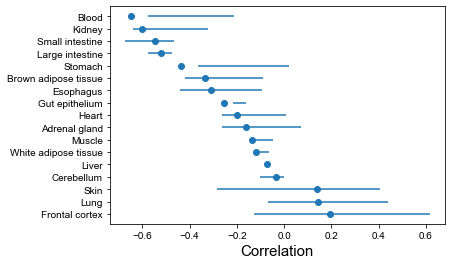

In [32]:
plt.errorbar(
    y=m['tissue'],
    x=m['corr'],
    marker='o',
    linestyle='none',
    xerr=[
        m['down_error'],
        m['upper_error']
    ]

)

plt.xlabel('Correlation', fontsize=15)


if save_images:
    export.export_image('{}/rank_by_tissue.pdf'.format(
        outfolder, mode))

In [33]:
m['center'] = m[['corr_first', 'corr_second']].mean(1)

In [34]:
m = m.sort_values('center', ascending=False)

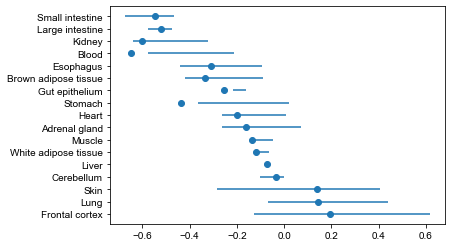

In [35]:
plt.errorbar(
    y=m['tissue'],
    x=m['corr'],
    marker='o',
    linestyle='none',
    xerr=[
        m['down_error'],
        m['upper_error']
    ]

)


if save_images:
    export.export_image('{}/rank_by_tissue_replicates.pdf'.format(
        outfolder, mode))

In [36]:
m

,condition,corr_first,pval_first,corr_second,pval_second,corr,pval,down,up,upper_error,down_error,tissue,older,center
15,Brain_0_4_24,-0.128151,4.6753e-41,0.615278,0,0.193236,7.13538e-96,-0.128151,0.615278,0.422042,0.321388,Frontal cortex,24.0,0.243564
47,Lung_0_4_24,-0.0671267,2.3734e-11,0.437565,8.29861e-220,0.143915,5.5887e-49,-0.067127,0.437565,0.29365,0.211041,Lung,24.0,0.185219
59,Skin_0_4_24,0.407185,0,-0.284306,5.65958e-21,0.140789,1.98503e-50,-0.284306,0.407185,0.266396,0.425095,Skin,24.0,0.061440
19,Cerebellum_0_4_24,-0.103064,5.10734e-29,-0.00159518,0.862162,-0.0331095,0.000495157,-0.103064,-0.001595,0.0315143,0.0699547,Cerebellum,24.0,-0.052330
43,Liver_0_4_24,-0.0646004,8.18796e-10,-0.0829326,4.70518e-13,-0.0708833,2.39865e-13,-0.082933,-0.064600,0.00628292,0.0120493,Liver,24.0,-0.073766
67,WAT_0_4_24,-0.110265,2.76137e-29,-0.0643805,3.5751e-11,-0.120297,3.76878e-33,-0.110265,-0.064381,0.0559163,-0.0100316,White adipose tissue,24.0,-0.087323
51,MuscSat_0_4_24,-0.0475096,1.77094e-06,-0.135875,5.49849e-44,-0.135331,1.04532e-39,-0.135875,-0.047510,0.0878217,0.000543481,Muscle,24.0,-0.091692
3,Adrenal_0_4_24,-0.26228,2.158e-163,0.0699734,1.91505e-11,-0.162002,1.07144e-58,-0.262280,0.069973,0.231975,0.100278,Adrenal gland,24.0,-0.096153
31,Heart_0_4_24,0.0100134,0.29428,-0.261528,1.7299e-156,-0.199111,4.54656e-101,-0.261528,0.010013,0.209125,0.0624167,Heart,24.0,-0.125757
63,Stomach_0_4_24,0.0210891,0.0350823,-0.364331,0,-0.438255,2.5601e-268,-0.364331,0.021089,0.459344,-0.0739235,Stomach,24.0,-0.171621
